Task 5 – Pivot Table + Stack/Unstack:

1. Tạo pivot tổng số liều tiêm theo nhóm tuổi × vaccine_type:

In [4]:
import pandas as pd
# Đọc dữ liệu từ file CSV:
vaccination = pd.read_csv(r"../data_clean/vaccination_record_clean.csv")
patient = pd.read_csv(r"../data_clean/patient_info_clean.csv")

# 1. Chuẩn hóa patient_id:
vaccination['patient_id'] = vaccination['patient_id'].str.upper().str.strip()
patient['patient_id'] = patient['patient_id'].str.upper().str.strip()

# 2. Chuẩn hóa nhóm tuổi:
patient['age_group'] = (
    patient['age_group']
    .str.strip()
    .str.replace('_', '-', regex=False)
    .replace({
        '50plus': '50+',
        '50 Plus': '50+'
    })
)

# 3. Chuẩn hóa vaccine_type:
vaccination['vaccine_type'] = (
    vaccination['vaccine_type']
    .str.strip()
    .str.lower()
    .replace({
        'covid': 'covid-19',
        'covid19': 'covid-19',
        'd.p.t': 'dpt'
    })
    .str.upper()
)

# 4. Merge dữ liệu:
df = vaccination.merge(
    patient[['patient_id', 'age_group']],
    on='patient_id',
    how='left'
)

# 5. Tạo pivot table:
sum_of_doses = pd.pivot_table(
    df,
    index='age_group',
    columns='vaccine_type',
    values='dose_number',
    aggfunc='count',
    fill_value=0
)
# Sắp xếp thứ tự nhóm tuổi:
age_sort = ['0-5', '6-17', '18-49', '50+']
pivot_sum_doses = sum_of_doses.reindex(age_sort)
print(" Bảng pivot tổng số liều tiêm theo nhóm tuổi × vaccine_type: ")
print(pivot_sum_doses)


 Bảng pivot tổng số liều tiêm theo nhóm tuổi × vaccine_type: 
vaccine_type  COVID-19  DPT  MMR
age_group                       
0-5                  1    5    6
6-17                17    6    9
18-49               14    9   12
50+                 10   12    5


2. Tạo pivot mức độ phản ứng trung bình theo vaccine_type × age_group:

In [5]:
import pandas as pd
import numpy as np
import re
# Đọc dữ liệu từ file CSV:
reaction = pd.read_csv("../data_clean/reaction_log_clean.csv")

# 1. Chuẩn hóa patient_id
reaction['patient_id'] = (
    reaction['patient_id']
    .astype(str)
    .str.upper()
    .str.strip()
)

# 2. Làm sạch severity:
def clean_severity(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if x == 'severe':
        return 3
# Lấy số đầu tiên nếu có:
    m = re.search(r'\d', x)
    if m:
        return int(m.group())
    return np.nan
reaction['severity_clean'] = reaction['severity'].apply(clean_severity)

# 3. Merge dữ liệu:
summary_df = (
    reaction
    .merge(vaccination[['patient_id', 'vaccine_type']], on='patient_id', how='left')
    .merge(patient[['patient_id', 'age_group']], on='patient_id', how='left')
)

# 4. Pivot table:
average_reaction_level = pd.pivot_table(
    summary_df,
    index='vaccine_type',
    columns='age_group',
    values='severity_clean',
    aggfunc='mean'
)
# Sắp xếp thứ tự nhóm tuổi:
age_sort = ['0-5', '6-17', '18-49', '50+']
pivot_avg_reaction = average_reaction_level.reindex(columns=age_sort)
print("\n Bảng pivot mức độ phản ứng trung bình theo vaccine_type × age_group: ")
print(pivot_avg_reaction.round(2))






 Bảng pivot mức độ phản ứng trung bình theo vaccine_type × age_group: 
age_group      0-5  6-17  18-49   50+
vaccine_type                         
COVID-19      1.00  1.26   1.70  1.48
DPT           1.29  1.12   1.71  1.61
MMR           2.17  1.88   1.55  1.09


3. Thực hành stack/unstack trên bảng kết quả:

3.1. Bảng tổng số liều tiêm theo nhóm tuổi × vaccine_type:
vaccine_type  COVID-19  DPT  MMR
age_group                       
0-5                  3    5    6
18-49               16   10   13
50+                 11   14    6
6-17                18    7   11

3.1.1. Stack() :

In [6]:
# Chuyển từ Dataframe có chỉ mục thông thường thành Series có multiply index:
stacked1 = sum_of_doses.stack()
stacked1


age_group  vaccine_type
0-5        COVID-19         1
           DPT              5
           MMR              6
18-49      COVID-19        14
           DPT              9
           MMR             12
50+        COVID-19        10
           DPT             12
           MMR              5
6-17       COVID-19        17
           DPT              6
           MMR              9
dtype: int64

In [7]:
# Chuyển từ multiply index thành bảng thường:
dataframe1 = stacked1.reset_index()
dataframe1.columns = ['age_group', 'vaccine_type', 'total_doses']
dataframe1

,age_group,vaccine_type,total_doses
0,0-5,COVID-19,1
1,0-5,DPT,5
2,0-5,MMR,6
3,18-49,COVID-19,14
4,18-49,DPT,9
5,18-49,MMR,12
6,50+,COVID-19,10
7,50+,DPT,12
8,50+,MMR,5
9,6-17,COVID-19,17


3.1.2. Unstack() :

In [8]:
# Chuyển từ Series đa cấp thành Dataframe thông thường:
unstacked1 = stacked1.unstack()
unstacked1



vaccine_type,COVID-19,DPT,MMR
age_group,,,
0-5,1,5,6
18-49,14,9,12
50+,10,12,5
6-17,17,6,9


In [9]:
# Đổi chiều bảng:
pivot_swapped1 = stacked1.unstack(level=0)
pivot_swapped1

age_group,0-5,18-49,50+,6-17
vaccine_type,,,,
COVID-19,1,14,10,17
DPT,5,9,12,6
MMR,6,12,5,9


3.2. Bảng mức độ phản ứng trung bình theo vaccine_type × age_group:
age_group      0-5  6-17  18-49   50+
vaccine_type                         
COVID-19      1.00  1.44   1.71  1.52
DPT           1.44  1.36   1.74  1.68
MMR           2.15  1.90   1.59  1.29

3.2.1. Stack() :

In [10]:
# Chuyển từ Dataframe có chỉ mục thông thường thành Series có multiply index:
stacked2 = pivot_avg_reaction.stack()
stacked2


vaccine_type  age_group
COVID-19      0-5          1.000000
              6-17         1.263158
              18-49        1.696970
              50+          1.478261
DPT           0-5          1.285714
              6-17         1.125000
              18-49        1.708333
              50+          1.606061
MMR           0-5          2.166667
              6-17         1.882353
              18-49        1.548387
              50+          1.090909
dtype: float64

In [11]:
# Chuyển từ multiply index thành bảng thường:
dataframe2 = stacked2.reset_index()
dataframe2.columns = ['vaccine_type', 'age_group', 'avg_reaction']
dataframe2

,vaccine_type,age_group,avg_reaction
0,COVID-19,0-5,1.000000
1,COVID-19,6-17,1.263158
2,COVID-19,18-49,1.696970
3,COVID-19,50+,1.478261
4,DPT,0-5,1.285714
5,DPT,6-17,1.125000
6,DPT,18-49,1.708333
7,DPT,50+,1.606061
8,MMR,0-5,2.166667
9,MMR,6-17,1.882353


3.2.2. Unstack() :

In [12]:
# Chuyển từ Series đa cấp thành Dataframe thông thường:
unstacked2 = stacked2.unstack()
unstacked2



age_group,0-5,6-17,18-49,50+
vaccine_type,,,,
COVID-19,1.000000,1.263158,1.696970,1.478261
DPT,1.285714,1.125000,1.708333,1.606061
MMR,2.166667,1.882353,1.548387,1.090909


In [13]:
# Đổi chiều bảng:
pivot_swapped2 = stacked2.unstack(level=0)
pivot_swapped2

vaccine_type,COVID-19,DPT,MMR
age_group,,,
0-5,1.000000,1.285714,2.166667
6-17,1.263158,1.125000,1.882353
18-49,1.696970,1.708333,1.548387
50+,1.478261,1.606061,1.090909


4. Tạo pivot đa cấp (MultiIndex) để thống kê số bệnh nhân, số lần tiêm và tỷ lệ có phản ứng 
trong cùng một bảng tổng hợp:

In [14]:
# Tạo cột “có phản ứng hay không” :
#Có phản ứng = reaction_type không rỗng và ≠ "Không phản ứng" :
summary_df['has_reaction'] = (
    summary_df['reaction_type']
    .fillna('')
    .str.strip()
    .str.lower()
    .ne('không phản ứng')
)


# Groupby và tính các chỉ số:
summary= (
    df
    .groupby(['vaccine_type', 'age_group'])
    .agg(
# Số bệnh nhân:
        patients=('patient_id', 'nunique'),
# Số lần tiêm:  
        doses=('patient_id', 'count'),
# Tỉ lệ phản ứng:
        reaction_rate=('has_reaction', 'mean')
    )
)
# Pivot đa cấp:
pivot_multi= summary.unstack('age_group')
# Sắp xếp thứ tự nhóm tuổi:
age_sort = ['0-5', '6-17', '18-49', '50+']
pivot_multi = pivot_multi.reindex(age_sort, axis=1, level=1)
# Định dạng tỷ lệ %:
pivot_multi['reaction_rate'] = pivot_multi['reaction_rate'] * 100
pivot_multi = pivot_multi.round(2)
print("\n Bảng pivot đa cấp để thống kê số bệnh nhân, số lần tiêm và tỷ lệ có phản ứng: ")
print(pivot_multi)



KeyError: "Column(s) ['has_reaction'] do not exist"

Biểu đồ cột nhóm:

In [ ]:
from matplotlib import pyplot as plt
pivot_multi['doses'].plot(kind='bar')
plt.ylabel('Number of doses')
plt.title(' Tổng số liều tiêm theo nhóm tuổi × vaccine_type')
plt.xticks(rotation=0)
plt.show()
plt.savefig('total_doses_by_agegroup_vaccinetype.png')


Biểu đồ đường:

In [ ]:
pivot_multi['reaction_rate'].T.plot(marker='o')
plt.ylabel('Reaction rate (%)')
plt.title(' Tỉ lệ có phản ứng theo vaccine_type × age_group')
plt.show()
plt.savefig('reaction_rate_by_vaccinetype_agegroup.png')


Heatmap:

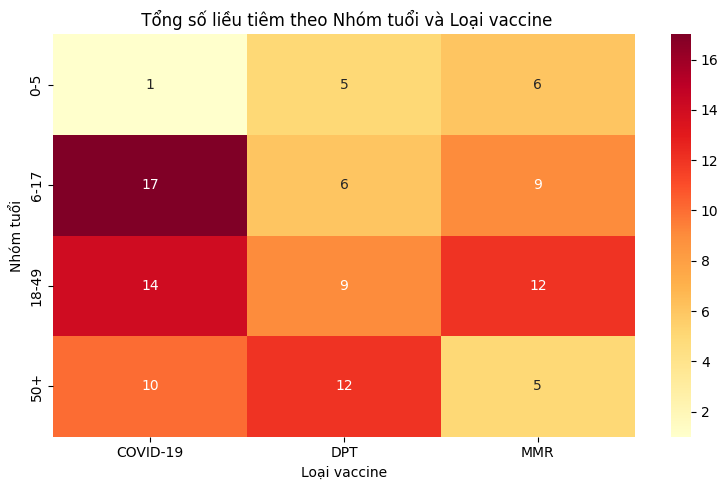

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot_sum_doses,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd'
)
plt.title(' Tổng số liều tiêm theo Nhóm tuổi và Loại vaccine')
plt.xlabel('Loại vaccine')
plt.ylabel('Nhóm tuổi')
plt.tight_layout()
plt.show()
plt.savefig('heatmap_total_doses_by_agegroup_vaccinetype.png')
